In [1]:
!module load qmio/hpc gcc/12.3.0 cunqa/0.3.1-python-3.9.9-mpi

qmio/hpc unloaded
        Preparing the environment for use of the sistema software stack.
        Please rebuild modules cache: module --ignore-cache avail
     
qmio/hpc loaded
gcccore/12.3.0 loaded
binutils/2.40 loaded
gcc/12.3.0 loaded
sqlite/3.45.3 loaded
libffi/3.4.2 loaded
python/3.9.9 loaded
nlohmann_json/3.11.3 loaded
rust/1.75.0 loaded
cmake/3.27.6 loaded

imkl/2023.2.0 loaded
ninja/1.9.0 loaded
meson/1.4.0-python-3.9.9 loaded
meson-python/0.16.0-python-3.9.9 loaded
cython/3.0.9-python-3.9.9 loaded
numpy/1.26.4-python-3.9.9 loaded
pythran/0.15.0-python-3.9.9 loaded
pybind11/2.12.0-python-3.9.9 loaded
xsimd/12.1.1 loaded
scipy/1.13.0-python-3.9.9 loaded
llvm/16.0.0 loaded
gmp/6.3.0 loaded
mpfr/4.2.1 loaded
mpc/1.3.1 loaded
flint/3.1.2 loaded
symengine/0.11.2 loaded
symengine-python/0.11.0-python-3.9.9 loaded
spdlog/1.9.2 loaded
pylatexenc/2.10-python-3.9.9 loaded
libgd/2.3.3 loaded
nasm/2.16.03 loaded
libjpeg-turbo/3.0.2 loaded
matplotlib/3.5.3-python-3.9.9 loaded
pandas/2.2.2

In [2]:
import os, sys

# path to access c++ files
sys.path.append(os.getenv("HOME"))

In [3]:
from cunqa import getQPUs

qpus  = getQPUs(local=False)

for q in qpus:
    print(f"QPU {q.id}, backend: {q.backend.name}, simulator: {q.backend.simulator}, version: {q.backend.version}.")


ImportError: Qiskit is installed in an invalid environment that has both Qiskit >=1.0 and an earlier version. You should create a new virtual environment, and ensure that you do not mix dependencies between Qiskit <1.0 and >=1.0. Any packages that depend on 'qiskit-terra' are not compatible with Qiskit 1.0 and will need to be updated. Qiskit unfortunately cannot enforce this requirement during environment resolution. See https://qisk.it/packaging-1-0 for more detail.

# Examples for optimizations

Before sending a circuit to the QClient, a transpilation process occurs (if not, it is done by the user). This process, in some cases, can take much time and resources, in addition to the sending cost itself. If we were to execute a single circuit once, it shouldn´t be a big problem, but it is when it comes to variational algorithms.

This quantum-classical algorithms require several executions of the same circuit but changing the value of the parameters, which are optimized in the classical part. In order to optimize this, we developed a functionallity that allows the user to upgrade the circuit parameters with no extra transpilations of the circuit, sending to the `QClient` the list of the parameters **ONLY**. This is of much advantage to speed up the computation in the cases in which transpilation takes a significant part of the total time of the simulation.

Let´s see how to work with this feature taking as an example a _Variational Quantum Algorithm_ for state preparation.

We start from a _Hardware Efficient Ansatz_ to build our parametrized circuit:

In [3]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

def hardware_efficient_ansatz(num_qubits, num_layers):
    qc = QuantumCircuit(num_qubits)
    param_idx = 0
    for _ in range(num_layers):
        for qubit in range(num_qubits):
            phi = Parameter(f'phi_{param_idx}_{qubit}')
            lam = Parameter(f'lam_{param_idx}_{qubit}')
            qc.ry(phi, qubit)
            qc.rz(lam, qubit)
        param_idx += 1
        for qubit in range(num_qubits - 1):
            qc.cx(qubit, qubit + 1)
    qc.measure_all()
    return qc

The we need a cost function. We will define a target distribution and measure how far we are from it. We choose to prepare a normal distribution among all the $2^n$ possible outcomes of the circuit.

In [4]:
def target_distribution(num_qubits):
    # Define a normal distribution over the states
    num_states = 2 ** num_qubits
    states = np.arange(num_states)
    mean = num_states / 2
    std_dev = num_states / 4
    target_probs = norm.pdf(states, mean, std_dev)
    target_probs /= target_probs.sum()  # Normalize to make it a valid probability distribution
    target_dist = {format(i, f'0{num_qubits}b'): target_probs[i] for i in range(num_states)}
    return target_dist

import pandas as pd
from scipy.stats import entropy, norm

def KL_divergence(counts, n_shots, target_dist):
    # Convert counts to probabilities
    pdf = pd.DataFrame.from_dict(counts, orient="index").reset_index()
    pdf.rename(columns={"index": "state", 0: "counts"}, inplace=True)
    pdf["probability"] = pdf["counts"] / n_shots
    
    # Create a dictionary for the obtained distribution
    obtained_dist = pdf.set_index("state")["probability"].to_dict()
    
    # Ensure all states are present in the obtained distribution
    for state in target_dist:
        if state not in obtained_dist:
            obtained_dist[state] = 0.0
    
    # Convert distributions to lists for KL divergence calculation
    target_probs = [target_dist[state] for state in sorted(target_dist)]
    obtained_probs = [obtained_dist[state] for state in sorted(obtained_dist)]
    
    # Calculate KL divergence
    kl_divergence = entropy(obtained_probs, target_probs)
    
    return kl_divergence
    

In [5]:
num_qubits = 6

num_layers = 3

n_shots = 1e5

### Simply using the `QPU.run()` method

At first we should try the intiutive alternative: upgrading parameters at the QClient, transpiling and sending the whole circuit to the QPU.

In [6]:
def cost_function_run(params):
    n_shots = 1e5
    target_dist = target_distribution(num_qubits)
    
    circuit = ansatz.assign_parameters(params)
    
    result = qpu.run(circuit, transpile = True, opt_level = 0, shots = n_shots).result
    
    counts = result.counts
    
    return KL_divergence(counts, n_shots, target_dist)

Our cost function updates the parameters given by the optimizer, asigns them to the ansatz and sends the circuit with the transpilation option set `True`. Let´s choose a QPU to work with and go ahead with the optimization:

In [7]:
import numpy as np
import time

qpu = qpus[0]

In [8]:
ansatz = hardware_efficient_ansatz(num_qubits, num_layers)

num_parameters = ansatz.num_parameters

initial_parameters = np.zeros(num_parameters)

from scipy.optimize import minimize

i = 0

cost_run = []
individuals_run = []

def callback(xk):
    global i
    e = cost_function_run(xk)
    individuals_run.append(xk)
    cost_run.append(e)
    if i%20 == 0:
        print(f"Iteration step {i}: f(x) = {e}")
    i+=1

tick = time.time()
optimization_result_run = minimize(cost_function_run, initial_parameters, method='COBYLA',
        callback=callback, tol = 0.01,
        options={
        'disp': True,     # Print info at the end
        'maxiter': 4000   # Limit the number of iterations
    })
tack = time.time()
time_run = tack-tick
print()
print("Total optimization time: ", time_run, " s")
print()

Iteration step 0: f(x) = 5.644885693319627
Iteration step 20: f(x) = 3.2489683099416027
Iteration step 40: f(x) = 0.700518505677799
Iteration step 60: f(x) = 0.5086090832144972
Iteration step 80: f(x) = 0.43838720938090936
Iteration step 100: f(x) = 0.3712628503801477
Iteration step 120: f(x) = 0.26705681526906927
Iteration step 140: f(x) = 0.19667531489860712
Iteration step 160: f(x) = 0.1557449733702997
Iteration step 180: f(x) = 0.12627009394865418
Iteration step 200: f(x) = 0.09875260103360035
Iteration step 220: f(x) = 0.0796950348124891
Iteration step 240: f(x) = 0.08664296063303309
Iteration step 260: f(x) = 0.07786113607509895
Iteration step 280: f(x) = 0.07138004921940413
Iteration step 300: f(x) = 0.06928285629833203
Iteration step 320: f(x) = 0.06625305423998329
Iteration step 340: f(x) = 0.06791448821860378
Iteration step 360: f(x) = 0.06584292813374018
Iteration step 380: f(x) = 0.06878749095657292

   Normal return from subroutine COBYLA

   NFVALS =  391   F = 6.630927E-

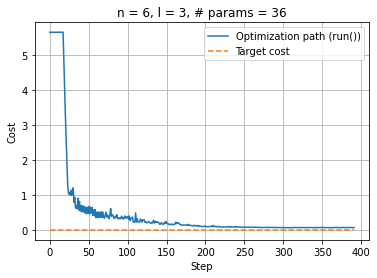

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.clf()
plt.plot(np.linspace(0, optimization_result_run.nfev, optimization_result_run.nfev), cost_run, label="Optimization path (run())")
upper_bound = optimization_result_run.nfev
plt.plot(np.linspace(0, upper_bound, upper_bound), np.zeros(upper_bound), "--", label="Target cost")
plt.xlabel("Step"); plt.ylabel("Cost"); plt.legend(loc="upper right"); plt.title(f"n = {num_qubits}, l = {num_layers}, # params = {num_parameters}")
plt.grid(True)
plt.show()
# plt.savefig(f"optimization_run_n_{num_qubits}_p_{num_parameters}.png", dpi=200)

### Using `QJob.upgrade_parameters()`

The first step now is to create the `qjob.QJob` object that which parameters we are going to upgrade in each step of the optimization; for that, we must run a circuit with initial parameters in a QPU, the procedure is as we explained above:

In [10]:
ansatz = hardware_efficient_ansatz(num_qubits, num_layers)

num_parameters = ansatz.num_parameters

initial_parameters = np.zeros(num_parameters)

circuit = ansatz.assign_parameters(initial_parameters)

qjob = qpu.run(circuit, transpile = True, opt_level = 0, shots = n_shots)

Now that we have sent to the virtual QPU the transpiled circuit, we can use the method `qjob.QJob.upgrade_parameters()` to change the rotations of the gates:

In [11]:
print("Result with initial_parameters: ")
print(qjob.result.counts)

random_parameters = np.random.uniform(0, 2 * np.pi, num_parameters).tolist()
print(random_parameters)
qjob.upgrade_parameters(random_parameters)

print()
print("Result with random_parameters: ")
print(qjob.result.counts)

Result with initial_parameters: 
{'000000': 100000}
[4.800769084169513, 1.2169894739610545, 4.308700639089514, 0.53228562699461, 4.572801942653737, 4.101667458095368, 1.085851890521249, 1.985892017022019, 4.0998922550688555, 2.6840994154719735, 2.9905197241774086, 2.9828536502963163, 2.193155663585044, 0.5546078957132934, 4.238713832258263, 5.409654114813467, 1.6005697271722092, 0.7034015057004601, 4.371946879506468, 1.264525265909713, 4.220949121372601, 3.541658508539978, 6.122463529488255, 1.4360914785130126, 1.2467862938893313, 1.1552122896705421, 1.7255569300107159, 1.4221512402804461, 3.6973504071781655, 5.528075365251304, 0.3505244857885771, 1.8120744822423005, 0.9420785391076939, 2.6013685195652054, 5.262298544374022, 3.4664558110869947]

Result with random_parameters: 
{'000000': 230, '000001': 1221, '000010': 57, '000011': 963, '000100': 1478, '000101': 2214, '000110': 2206, '000111': 126, '001000': 1082, '001001': 247, '001010': 265, '001011': 1762, '001100': 600, '001101': 2

**Important considerations:**

- The method acepts parameters in a `list`, if you have a `numpy.array`, simply apply `.tolist()` to transform it.

- When sending the circuit and setting `transpile=True`, we should be carefull that the transpilation process doesn't condense gates and combine parameters, therefore, if the user wants `cunqa`to transpile, they must set `opt_level=0`.

Note that `qjob.QJob.upgrade_parameters()` is a non-blocking call, as it was `qpu.QPU.run()`.

Now that we are familiar with the procedure, we can design a cost funtion that takes a set of parameters, upgrades the `qjob.QJob`, gets the result and calculates the divergence from the desired distribution:

In [12]:
def cost_function(params):
    n_shots = 100000
    target_dist = target_distribution(num_qubits)
    
    qjob.upgrade_parameters(params.tolist())
    
    counts = qjob.result.counts
    
    return KL_divergence(counts, n_shots, target_dist)


Now we are ready to start our optimization. We will use `scipy.optimize` to minimize the divergence of our result distribution from the target one:

In [13]:
from scipy.optimize import minimize
import time

i = 0

initial_parameters = np.zeros(num_parameters)

cost = []
individuals = []

def callback(xk):
    global i
    e = cost_function(xk)
    individuals.append(xk)
    cost.append(e)
    if i%10 == 0:
        print(f"Iteration step {i}: f(x) = {e}")
    i+=1

tick = time.time()
optimization_result = minimize(cost_function, initial_parameters, method='COBYLA',
        callback=callback, tol = 0.01,
        options={
        'disp': True,     # Print info during iterations
        'maxiter': 4000     # Limit the number of iterations
    })
tack = time.time()
time_up = tack-tick
print()
print("Total optimization time: ", time_up, " s")

Iteration step 0: f(x) = 4.808127828547751
Iteration step 10: f(x) = 3.2277447214466535
Iteration step 20: f(x) = 1.4546159328320607
Iteration step 30: f(x) = 0.8280370465217498
Iteration step 40: f(x) = 0.7268863480351391
Iteration step 50: f(x) = 0.6002777280561791
Iteration step 60: f(x) = 0.6310585988580937
Iteration step 70: f(x) = 0.531624604820937
Iteration step 80: f(x) = 0.49413409044044915
Iteration step 90: f(x) = 0.28276705189385987
Iteration step 100: f(x) = 0.28315153947896776
Iteration step 110: f(x) = 0.20441926998831558
Iteration step 120: f(x) = 0.20818472830794493
Iteration step 130: f(x) = 0.20255824135914952
Iteration step 140: f(x) = 0.17140823564605984
Iteration step 150: f(x) = 0.17354475356274046
Iteration step 160: f(x) = 0.15458380797622073
Iteration step 170: f(x) = 0.1711286646144804
Iteration step 180: f(x) = 0.18543970743296512
Iteration step 190: f(x) = 0.13357890094906225
Iteration step 200: f(x) = 0.12809092212518816
Iteration step 210: f(x) = 0.125992

We can plot the evolution of the cost function during the optimization:

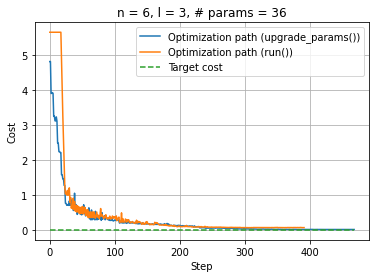

In [14]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.clf()
plt.plot(np.linspace(0, optimization_result.nfev, optimization_result.nfev), cost, label="Optimization path (upgrade_params())")
plt.plot(np.linspace(0, optimization_result_run.nfev, optimization_result_run.nfev), cost_run, label="Optimization path (run())")
upper_bound = max(optimization_result_run.nfev, optimization_result.nfev)
plt.plot(np.linspace(0, upper_bound, upper_bound), np.zeros(upper_bound), "--", label="Target cost")
plt.xlabel("Step"); plt.ylabel("Cost"); plt.legend(loc="upper right"); plt.title(f"n = {num_qubits}, l = {num_layers}, # params = {num_parameters}")
plt.grid(True)
plt.show()
# plt.savefig(f"optimization_n_{num_qubits}_p_{num_parameters}.png", dpi=200)